In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [119]:
#import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import cv2
import os
from glob import glob
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import warnings
warnings.filterwarnings('ignore')

In [343]:
#define a function to evaluate the model
#using the validation dataset

def evaluate_model (model):
    """
    evaluate the accuracy and loss of the model
    input: keras model
    """
    model = model
    print('Acuracy of the model is: ',model.evaluate_generator(val_generator)[1]*100, "%")
    print('Loss of the model is: ', model.evaluate_generator(val_generator)[0])
    
    

In [318]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [319]:
#downloading data from folder
train_dir = '../../Data/chest_xray/train'
test_dir = '../../Data/chest_xray/test'
val_dir = '../../Data/chest_xray/val'
# train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
# test_dir =  '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
# val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [321]:
#Define function that will help split our data into X and Y and resize it 
def picture_separation(folder):
    """
    source code from:https://medium.com/analytics-vidhya/how-to-load-any-image-dataset-in-python-3bd2fa2cb43d
    and https://www.kaggle.com/rafetcan/
    input: folder
    """
    y = []
    x = []
    image_list = []

    for foldername in os.listdir(folder):
        if not foldername.startswith('.'):
            if foldername == "NORMAL":
                label = 0
            elif foldername == "PNEUMONIA":
                label = 1
            else:
                label = 2
                
            for image_filename in os.listdir(folder + "/"+ foldername):
                img_file = cv2.imread(folder + "/" + foldername + '/' + image_filename,0)               
                if img_file is not None:
                    img = cv2.resize(img_file,(64,64)) #resize img
                    img_arr = img_to_array(img) / 255
                    x.append(img_arr)
                    y.append(label)
                    image_list.append(foldername + '/' + image_filename)
                                        
    X = np.asarray(x) #create an array of images for X
    y = np.asarray(y) #create an array of images for y
    
    

    return X,y,image_list


In [322]:
#put the images in a dataframe 
X_train, y_train, img_train = picture_separation(train_dir)

train_df = pd.DataFrame(img_train, columns=["images"])
train_df["target"] = y_train

In [323]:
#checking the shape of the X_train 
X_train.shape

(5216, 64, 64, 1)

In [324]:
#checking the shape of the y_train 
y_train.shape

(5216,)

In [325]:
#check the first 4 rows of the train dataset
train_df.head()

,images,target
0,PNEUMONIA/person63_bacteria_306.jpeg,1
1,PNEUMONIA/person1438_bacteria_3721.jpeg,1
2,PNEUMONIA/person755_bacteria_2659.jpeg,1
3,PNEUMONIA/person478_virus_975.jpeg,1
4,PNEUMONIA/person661_bacteria_2553.jpeg,1


In [326]:
#check the info of the train dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5216 entries, 0 to 5215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  5216 non-null   object
 1   target  5216 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 81.6+ KB


In [327]:
#put the val dataset in a dataframe 
X_val, y_val, img_val = picture_separation(val_dir)

val_df = pd.DataFrame(img_val, columns=["images"])
val_df["target"] = y_val

In [328]:
X_val.shape

(16, 64, 64, 1)

In [329]:
#put the test dataset in a dataframe 
X_test, y_test, img_test = picture_separation(test_dir)

test_df = pd.DataFrame(img_test, columns=["images"])
test_df["target"] = y_test

In [330]:
X_test.shape

(624, 64, 64, 1)

In [331]:
#concat the dataset into a dataframe 
#so that we can see the shape and the info
full_data = pd.concat([train_df, test_df, val_df], axis=0, ignore_index=True)

In [332]:
#view the first four rows and the last five rows
print(full_data.head())
print(full_data.tail())

                                    images  target
0     PNEUMONIA/person63_bacteria_306.jpeg       1
1  PNEUMONIA/person1438_bacteria_3721.jpeg       1
2   PNEUMONIA/person755_bacteria_2659.jpeg       1
3       PNEUMONIA/person478_virus_975.jpeg       1
4   PNEUMONIA/person661_bacteria_2553.jpeg       1
                                images  target
5851  NORMAL/NORMAL2-IM-1436-0001.jpeg       0
5852  NORMAL/NORMAL2-IM-1430-0001.jpeg       0
5853  NORMAL/NORMAL2-IM-1438-0001.jpeg       0
5854  NORMAL/NORMAL2-IM-1442-0001.jpeg       0
5855  NORMAL/NORMAL2-IM-1427-0001.jpeg       0


In [333]:
full_data.shape

(5856, 2)

In [334]:
#view the full dataset info
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   images  5856 non-null   object
 1   target  5856 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 91.6+ KB


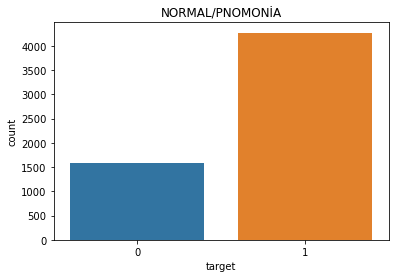

1    72.967896
0    27.032104
Name: target, dtype: float64


In [335]:
#checking if the target is balance 
sns.countplot(full_data["target"])
plt.title("NORMAL/PNOMONİA")
plt.show()
print(full_data["target"].value_counts(normalize=True)*100)

**Observation** 
- Clearly, the data seems to be imbalanced in this case. Now in order to balance the distribution of the training examples, we would be using data augmentation procedure. first let's visualize the images to see the X-ray that is Normal and not Normal(Pneumonia).


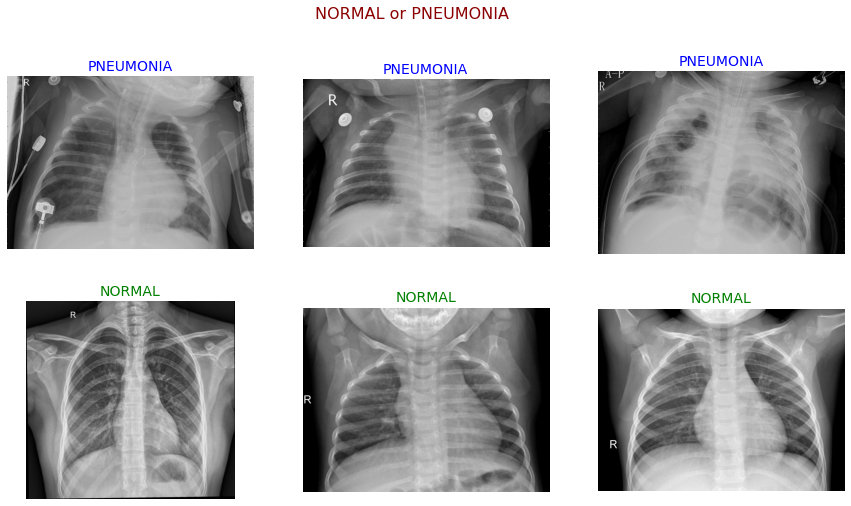

In [336]:
#plot the images that is normal and Pneumonia
plt.figure(figsize=(15,8))

plt.subplot(2,3,1) 
img = load_img(train_dir + "/" + full_data["images"][0])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")


plt.subplot(2,3,2) 
img = load_img(train_dir + "/" + full_data["images"][1])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")

plt.subplot(2,3,3) 
img = load_img(train_dir + "/" + full_data["images"][10])
plt.imshow(img)
plt.title("PNEUMONIA", color = "blue", size = 14)
plt.axis("off")

plt.subplot(2,3,4) 
img = load_img(train_dir + "/" + full_data["images"][3875])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.subplot(2,3,5) 
img = load_img(train_dir + "/" + full_data["images"][3876])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.subplot(2,3,6) 
img = load_img(train_dir + "/" + full_data["images"][3877])
plt.imshow(img)
plt.title("NORMAL", color = "green", size = 14)
plt.axis("off")

plt.suptitle("NORMAL or PNEUMONIA", size = 16, color = "darkred")
plt.show()

# Data Augmentation
- Data augmentation is used to increase the size of our data based on the existing data. it acts asa regularizer to help reduce overfitting, especially in this case where we have an imbalanced target.

In [337]:
# Fitting the CNN to the images
# The function ImageDataGenerator augments your image by iterating through image as your CNN is getting ready to process that image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.3,
                                   brightness_range=(0.9,1),
                                   zoom_range = 0.3,
                                   validation_split= 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)  #Image normalization.

val_datagen = ImageDataGenerator(rescale = 1./255) #Image normalization.

training_generator = train_datagen.flow_from_directory(train_dir,
                                                       target_size = (64, 64),
                                                       batch_size = 32,
                                                       subset = 'training',
                                                       color_mode='grayscale',
                                                       class_mode = 'binary')

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(64, 64),
                                                  batch_size=32,
                                                  color_mode='grayscale',
                                                  class_mode='binary')

val_generator = train_datagen.flow_from_directory(train_dir,
                                                  target_size = (64, 64),
                                                  batch_size = 32,
                                                  class_mode = 'binary',
                                                  color_mode='grayscale',
                                                  subset ='validation')

Found 4695 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 521 images belonging to 2 classes.


In [338]:
#define an input shape so that we can use it for modeling
input_shape = X_train.shape[1:]
input_shape

(64, 64, 1)

# Modeling

## First Model

In [339]:
#Instantiate sequential and add input layer
model = Sequential()
model.add(Conv2D(32,(3,3),activation = 'relu',padding='same',input_shape = input_shape))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D())

#Layers
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D())

#layers
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D())

#output
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])


In [340]:
#get the model summary
model.summary()

Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_333 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_334 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_184 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_335 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_336 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_185 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_337 (Conv2D)          (None, 16, 16, 64)      

In [341]:
#examine the accuracy score and the loss score using the holdout training validation set.
history = model.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs =20,
                             validation_data = val_generator,
                             validation_steps= 521//32)
#                              callbacks=[early_stopping])

Epoch 1/20
146/146 [==============================] - 61s 421ms/step - loss: 0.4524 - accuracy: 0.7849 - val_loss: 0.3927 - val_accuracy: 0.7910
Epoch 2/20
146/146 [==============================] - 59s 406ms/step - loss: 0.2598 - accuracy: 0.8915 - val_loss: 0.3163 - val_accuracy: 0.8379
Epoch 3/20
146/146 [==============================] - 59s 402ms/step - loss: 0.2374 - accuracy: 0.9016 - val_loss: 0.2939 - val_accuracy: 0.8730
Epoch 4/20
146/146 [==============================] - 62s 424ms/step - loss: 0.1977 - accuracy: 0.9275 - val_loss: 0.2406 - val_accuracy: 0.9023
Epoch 5/20
146/146 [==============================] - 63s 429ms/step - loss: 0.1728 - accuracy: 0.9367 - val_loss: 0.2436 - val_accuracy: 0.9180
Epoch 6/20
146/146 [==============================] - 62s 425ms/step - loss: 0.1613 - accuracy: 0.9385 - val_loss: 0.2478 - val_accuracy: 0.8926
Epoch 7/20
146/146 [==============================] - 63s 430ms/step - loss: 0.1454 - accuracy: 0.9427 - val_loss: 0.2412 - val_ac

In [345]:
#evaluate model
evaluate_model(model)

Acuracy of the model is:  92.51439571380615 %
Loss of the model is:  0.16782252490520477


In [259]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

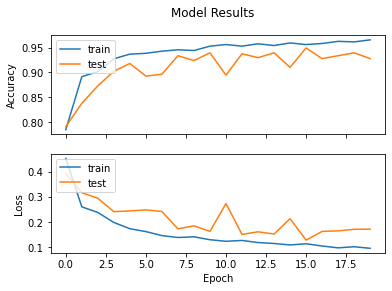

In [346]:
#plot the accuracy and loss on a graph to visualize how the model is doing.
visualize_training_results(history)

## Second Model

In [364]:
#build second model
model1 = Sequential()
model1.add(Conv2D(32,(3,3),activation = 'relu',padding='same',input_shape = input_shape))
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


#Layers
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


#layers
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D())


#output
model1.add(Flatten())
model1.add(Dense(1200, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])


In [365]:
model1.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_369 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_370 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
batch_normalization_148 (Bat (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_202 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_371 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_372 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_149 (Bat (None, 32, 32, 32)      

In [366]:
#we are creating a early stopping so that when our 
#model reaches the desired level we can stop it
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [367]:
results = model1.fit_generator(training_generator,
                             steps_per_epoch= 4695//32,
                             epochs =30,
                             validation_data = val_generator,
                             validation_steps= 521//32,
                             callbacks=[early_stopping])

Epoch 1/30
146/146 [==============================] - 63s 430ms/step - loss: 0.5257 - accuracy: 0.8692 - val_loss: 1.4544 - val_accuracy: 0.7441
Epoch 2/30
146/146 [==============================] - 63s 429ms/step - loss: 0.2330 - accuracy: 0.9080 - val_loss: 2.1685 - val_accuracy: 0.7422
Epoch 3/30
146/146 [==============================] - 64s 440ms/step - loss: 0.2011 - accuracy: 0.9247 - val_loss: 1.1105 - val_accuracy: 0.7637
Epoch 4/30
146/146 [==============================] - 61s 416ms/step - loss: 0.1642 - accuracy: 0.9402 - val_loss: 0.2142 - val_accuracy: 0.8965
Epoch 5/30
146/146 [==============================] - 62s 422ms/step - loss: 0.1703 - accuracy: 0.9354 - val_loss: 1.2350 - val_accuracy: 0.7715
Epoch 6/30
146/146 [==============================] - 61s 418ms/step - loss: 0.1647 - accuracy: 0.9393 - val_loss: 0.2141 - val_accuracy: 0.8848
Epoch 7/30
146/146 [==============================] - 61s 418ms/step - loss: 0.1632 - accuracy: 0.9376 - val_loss: 0.2210 - val_ac

In [368]:
#evaluate the model
evaluate_model(model1)

Acuracy of the model is:  86.94817423820496 %
Loss of the model is:  0.27297642827033997


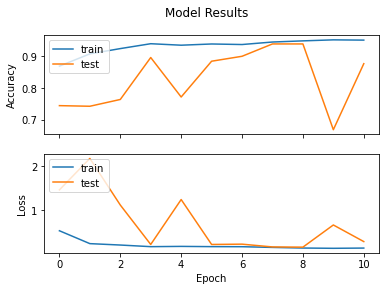

In [370]:
#visualize the results
visualize_training_results(results)

## Third Model

In [373]:
#build third model
model2 = Sequential()
model2.add(Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape))
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2)))

#Layers
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(Conv2D(32,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2)))

#layers

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(MaxPooling2D((2,2)))


#output
model2.add(Flatten())
model2.add(Dense(900, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])


In [377]:
model2.summary()

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_391 (Conv2D)          (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_392 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_211 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_393 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_394 (Conv2D)          (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_212 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_395 (Conv2D)          (None, 11, 11, 64)      

In [378]:
results2= model2.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs = 5,
                             validation_data = val_generator,
                             validation_steps= 521//32)
                             

Epoch 1/5
146/146 [==============================] - 58s 399ms/step - loss: 0.5527 - accuracy: 0.7399 - val_loss: 0.4466 - val_accuracy: 0.7500
Epoch 2/5
146/146 [==============================] - 59s 408ms/step - loss: 0.3681 - accuracy: 0.8340 - val_loss: 0.3732 - val_accuracy: 0.8320
Epoch 3/5
146/146 [==============================] - 60s 408ms/step - loss: 0.2985 - accuracy: 0.8780 - val_loss: 0.3608 - val_accuracy: 0.8398
Epoch 4/5
146/146 [==============================] - 59s 402ms/step - loss: 0.2623 - accuracy: 0.8917 - val_loss: 0.2562 - val_accuracy: 0.8848
Epoch 5/5
146/146 [==============================] - 58s 398ms/step - loss: 0.2305 - accuracy: 0.9050 - val_loss: 0.2834 - val_accuracy: 0.8789


In [379]:
evaluate_model(model2)

Acuracy of the model is:  88.86756300926208 %
Loss of the model is:  0.27949050068855286


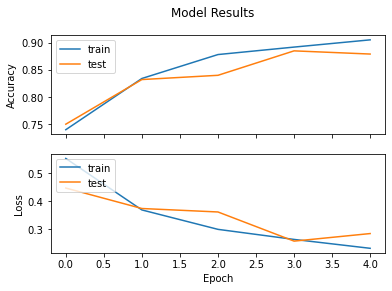

In [380]:
visualize_training_results(results2)

## Fourth Model

In [383]:
model3 = Sequential()
model3.add(Conv2D(32,(3,3),activation = 'relu',padding='same',input_shape = input_shape))
model3.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model3.add(MaxPooling2D((2,2),strides=(2,2)))

#Layers
model3.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model3.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model3.add(MaxPooling2D((2,2),strides=(2,2)))

#layers
model3.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model3.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model3.add(MaxPooling2D((2,2), strides = (2,2)))

#output
model3.add(Flatten())
model3.add(Dense(900, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])


In [384]:
model3.summary()

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_401 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_402 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_215 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_403 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_404 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_216 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_405 (Conv2D)          (None, 16, 16, 64)      

In [385]:
results3= model3.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs = 15,
                             validation_data = val_generator,
                             validation_steps= 521//32)

Epoch 1/15
146/146 [==============================] - 62s 422ms/step - loss: 0.5014 - accuracy: 0.7677 - val_loss: 0.3175 - val_accuracy: 0.8594
Epoch 2/15
146/146 [==============================] - 62s 426ms/step - loss: 0.2788 - accuracy: 0.8855 - val_loss: 0.3167 - val_accuracy: 0.8438
Epoch 3/15
146/146 [==============================] - 60s 410ms/step - loss: 0.2477 - accuracy: 0.9020 - val_loss: 0.2893 - val_accuracy: 0.8750
Epoch 4/15
146/146 [==============================] - 61s 420ms/step - loss: 0.2019 - accuracy: 0.9224 - val_loss: 0.2389 - val_accuracy: 0.8848
Epoch 5/15
146/146 [==============================] - 60s 411ms/step - loss: 0.1864 - accuracy: 0.9262 - val_loss: 0.2277 - val_accuracy: 0.9141
Epoch 6/15
146/146 [==============================] - 62s 422ms/step - loss: 0.1754 - accuracy: 0.9367 - val_loss: 0.2407 - val_accuracy: 0.8906
Epoch 7/15
146/146 [==============================] - 61s 415ms/step - loss: 0.1579 - accuracy: 0.9421 - val_loss: 0.2361 - val_ac

In [386]:
evaluate_model(model3)

Acuracy of the model is:  92.70633459091187 %
Loss of the model is:  0.16988059878349304


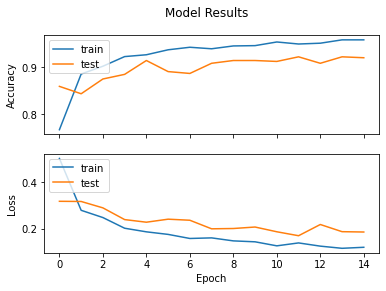

In [387]:
visualize_training_results(results3)

## Fifth Model

In [388]:
model4 = Sequential()
model4.add(Conv2D(32,(3,3),activation = 'relu',input_shape = input_shape))
model4.add(Conv2D(32,(3,3),activation='relu',kernel_regularizer=l2(0.0005)))
model4.add(MaxPooling2D((2,2),strides=(2,2)))

#Layers
model4.add(Conv2D(32,(3,3),activation='relu',kernel_regularizer=l2(0.0005)))
model4.add(Conv2D(32,(3,3),activation='relu',kernel_regularizer=l2(0.0005)))
model4.add(MaxPooling2D((2,2),strides=(2,2)))

#layers
model4.add(Conv2D(64,(3,3),activation='relu',kernel_regularizer=l2(0.0005)))
model4.add(Conv2D(64,(3,3),activation='relu',kernel_regularizer=l2(0.0005)))
model4.add(MaxPooling2D((2,2), strides = (2,2)))

#output
model4.add(Flatten())
model4.add(Dense(900, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(1, activation='sigmoid'))

model4.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])


In [390]:
model4.summary()

Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_407 (Conv2D)          (None, 62, 62, 32)        320       
_________________________________________________________________
conv2d_408 (Conv2D)          (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_409 (Conv2D)          (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_410 (Conv2D)          (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_219 (MaxPoolin (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_411 (Conv2D)          (None, 11, 11, 64)      

In [389]:
results4= model4.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs = 15,
                             validation_data = val_generator,
                             validation_steps= 521//32)

Epoch 1/15
146/146 [==============================] - 58s 395ms/step - loss: 0.4964 - accuracy: 0.7866 - val_loss: 0.3650 - val_accuracy: 0.8242
Epoch 2/15
146/146 [==============================] - 58s 394ms/step - loss: 0.3174 - accuracy: 0.8786 - val_loss: 0.3375 - val_accuracy: 0.8477
Epoch 3/15
146/146 [==============================] - 60s 409ms/step - loss: 0.2915 - accuracy: 0.8893 - val_loss: 0.2713 - val_accuracy: 0.8730
Epoch 4/15
146/146 [==============================] - 59s 403ms/step - loss: 0.2775 - accuracy: 0.8994 - val_loss: 0.3370 - val_accuracy: 0.8457
Epoch 5/15
146/146 [==============================] - 67s 457ms/step - loss: 0.2669 - accuracy: 0.8979 - val_loss: 0.2741 - val_accuracy: 0.8867
Epoch 6/15
146/146 [==============================] - 58s 395ms/step - loss: 0.2425 - accuracy: 0.9138 - val_loss: 0.2888 - val_accuracy: 0.8828
Epoch 7/15
146/146 [==============================] - 57s 390ms/step - loss: 0.2161 - accuracy: 0.9247 - val_loss: 0.2514 - val_ac

In [391]:
evaluate_model(model4)

Acuracy of the model is:  93.85796785354614 %
Loss of the model is:  0.2388487607240677


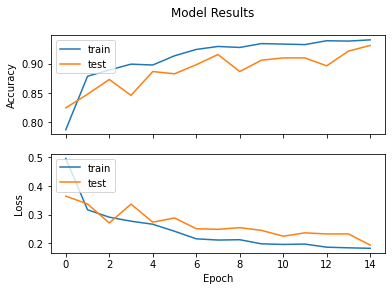

In [392]:
visualize_training_results(results4)

In [407]:
model5 = Sequential()
model5.add(Conv2D(32,(3,3),activation = 'relu',padding='same',input_shape = input_shape))
model5.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model5.add(MaxPooling2D(strides=(2,2)))

#Layers
model5.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model5.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model5.add(MaxPooling2D(strides=(2,2)))

#layers
model5.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model5.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model5.add(MaxPooling2D(strides=(2,2)))

#output
model5.add(Flatten())
model5.add(Dense(300, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(1, activation='sigmoid'))

model5.compile(loss='binary_crossentropy',
             optimizer ='adam',
             metrics=['accuracy'])


In [408]:
model5.summary()

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_433 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_434 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_231 (MaxPoolin (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_435 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_436 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_232 (MaxPoolin (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_437 (Conv2D)          (None, 16, 16, 64)      

In [410]:
results5= model5.fit_generator(training_generator,
                             steps_per_epoch=4695//32,
                             epochs = 8,
                             validation_data = val_generator,
                             validation_steps= 521//32)

Epoch 1/8
146/146 [==============================] - 57s 393ms/step - loss: 0.3097 - accuracy: 0.8636 - val_loss: 0.3098 - val_accuracy: 0.8516
Epoch 2/8
146/146 [==============================] - 58s 399ms/step - loss: 0.2500 - accuracy: 0.8973 - val_loss: 0.2902 - val_accuracy: 0.8711
Epoch 3/8
146/146 [==============================] - 56s 384ms/step - loss: 0.2100 - accuracy: 0.9164 - val_loss: 0.2135 - val_accuracy: 0.9062
Epoch 4/8
146/146 [==============================] - 57s 387ms/step - loss: 0.1968 - accuracy: 0.9269 - val_loss: 0.2153 - val_accuracy: 0.9082
Epoch 5/8
146/146 [==============================] - 55s 379ms/step - loss: 0.1839 - accuracy: 0.9282 - val_loss: 0.1914 - val_accuracy: 0.9141
Epoch 6/8
146/146 [==============================] - 56s 382ms/step - loss: 0.1608 - accuracy: 0.9335 - val_loss: 0.2025 - val_accuracy: 0.9219
Epoch 7/8
146/146 [==============================] - 56s 380ms/step - loss: 0.1457 - accuracy: 0.9419 - val_loss: 0.2029 - val_accuracy:

In [411]:
evaluate_model(model5)

Acuracy of the model is:  91.7466402053833 %
Loss of the model is:  0.21266482770442963


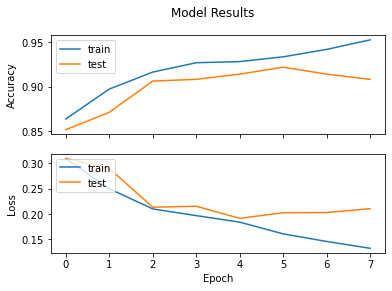

In [412]:
visualize_training_results(results5)

Using the Conv2d model, Our Model is better compared to our baseline Model, despite the fact that it was evaluated based on the validation holdout set. We are able to generate an accuracy score of over 90% after tuning the models.  we will be comparing the models with the cnn pretrained model in order to finalize the model that will predict on the test dataset(Unseen data) for more accuracy. 